# Dynamic Programming - Group 'Lost in Optimization' - Main python notebook

Install dependencies and set magics:

In [1]:
%load_ext autoreload
%autoreload 2

#%pip install EconModel
#%pip install ConSav
#%pip install quantecon

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
nb.set_num_threads(4) #perhaps set to 8

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Initial solve of the models

Set amount of periods:

In [2]:
model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':False})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()

1
0
1
2
0
0
1
2
59
0
1
2
58
0
1
2
57
0
1
2
56
0
1
2
55
0
1
2
54
0
1
2
53
0
1
2
52
0
1
2
51
0
1
2
50
0
1
2
49
0
1
2
48
0
1
2
47
0
1
2
46
0
1
2
45
0
1
2
44
0
1
2
43
0
1
2
42
0
1
2
41
0
1
2
40
0
1
2
39
0
1
2
38
0
1
2
37
0
1
2
36
0
1
2
35
0
1
2
34
0
1
2
33
0
1
2
32
0
1
2
31
0
1
2
30
0
1
2
29
0
1
2
28
0
1
2
27
0
1
2
26
0
1
2
25
0
1
2
24
0
1
2
23
0
1
2
22
0
1
2
21
0
1
2
20
0
1
2
19
0
1
2
18
0
1
2
17
0
1
2
16
0
1
2
15
0
1
2
14
0
1
2
13
0
1
2
12
0
1
2
11
0
1
2
10
0
1
2
9
0
1
2
8
0
1
2
7
0
1
2
6
0
1
2
5
0
1
2
4
0
1
2
3
0
1
2
2
0
1
2
1
0
1
2
0
0
1
2


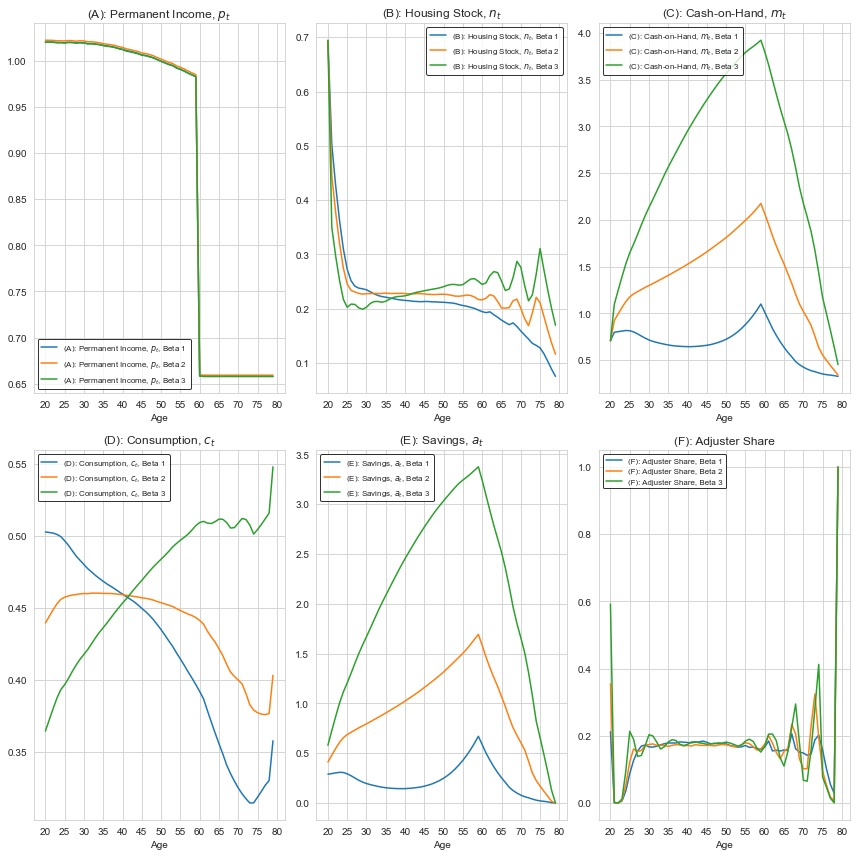

In [3]:
model_negm.lifecycle()

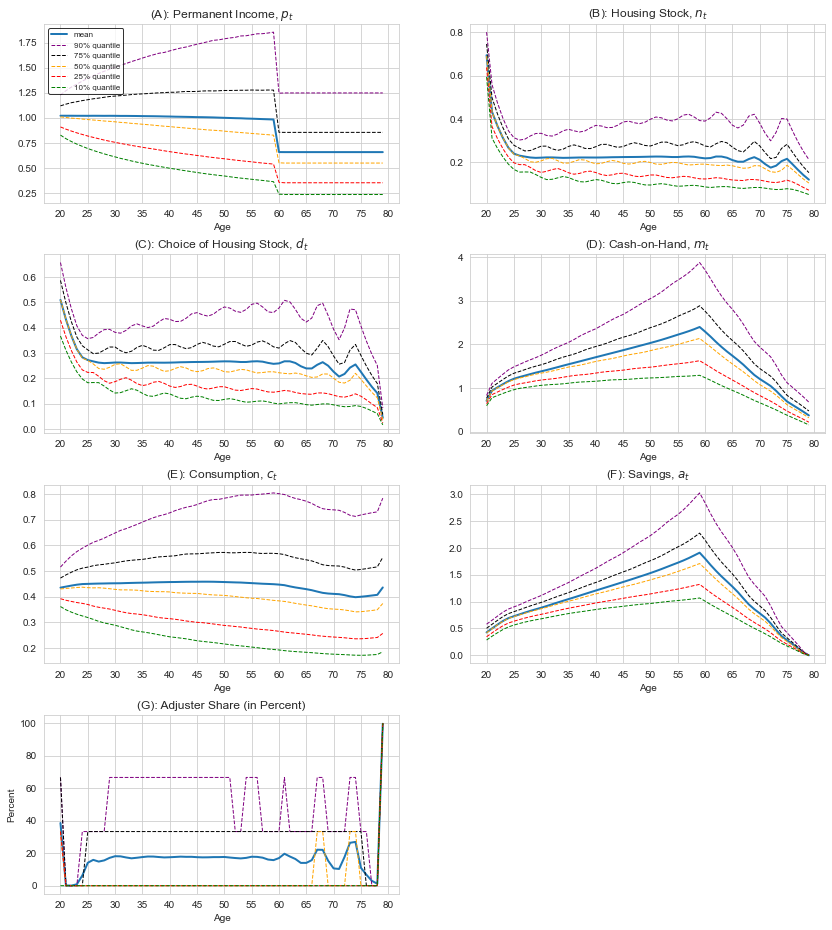

In [14]:
model_negm.lifecycle_rand()

# Tax Shocks

## Transitory Anticipated Tax Increase

Create a copy of the original model solve with NEGM and implement anticipated transitory tax increase in period 20 (i.e. 21):

In [16]:
model_negm_trans5pct = model_negm.copy()
model_negm_trans5pct.par.tax_rate_vec[20] = model_negm.par.tax_rate_vec[20]*1.05

Check tax array to see that a transitory shock has been implemented:

In [18]:
# ensuring tax has hikened
model_negm_trans5pct.par.tax_rate_vec

array([0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.5355, 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  ])

Solve and simulate new model with anticipated transitory shock:

In [20]:
model_negm_trans5pct.solve()
model_negm_trans5pct.simulate()

59
0
1
2
58
0
1
2
57
0
1
2
56
0
1
2
55
0
1
2
54
0
1
2
53
0
1
2
52
0
1
2
51
0
1
2
50
0
1
2
49
0
1
2
48
0
1
2
47
0
1
2
46
0
1
2
45
0
1
2
44
0
1
2
43
0
1
2
42
0
1
2
41
0
1
2
40
0
1
2
39
0
1
2
38
0
1
2
37
0
1
2
36
0
1
2
35
0
1
2
34
0
1
2
33
0
1
2
32
0
1
2
31
0
1
2
30
0
1
2
29
0
1
2
28
0
1
2
27
0
1
2
26
0
1
2
25
0
1
2
24
0
1
2
23
0
1
2
22
0
1
2
21
0
1
2
20
0
1
2
19
0
1
2
18
0
1
2
17
0
1
2
16
0
1
2
15
0
1
2
14
0
1
2
13
0
1
2
12
0
1
2
11
0
1
2
10
0
1
2
9
0
1
2
8
0
1
2
7
0
1
2
6
0
1
2
5
0
1
2
4
0
1
2
3
0
1
2
2
0
1
2
1
0
1
2
0
0
1
2


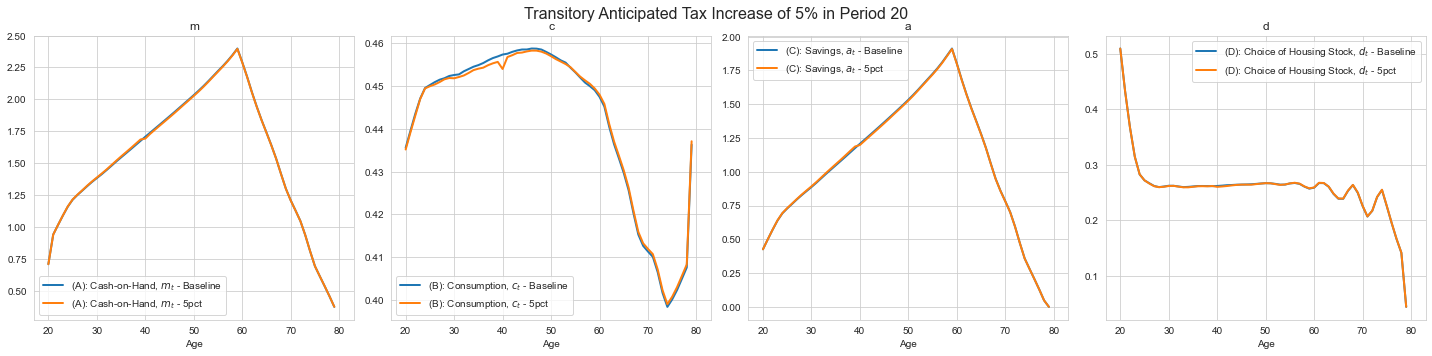

In [50]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# a. unpack
par = model_negm.par
sim = model_negm.sim
sim_trans5pct = model_negm_trans5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Choice of Housing Stock, $d_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Transitory Anticipated Tax Increase of 5% in Period 20", fontsize=16)

age = np.arange(par.T)

for i, (simvar, simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar)
    simdata_trans5pct = getattr(sim_trans5pct, simvar)
    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, label=f'{simvarlatex} - Baseline')
    axs[i].plot(age, np.mean(simdata_trans5pct, axis=(1,2)), lw=2, label=f'{simvarlatex} - 5pct')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvar}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

## Permanent Anticipated Tax Increase

Create a copy of the original model solve with NEGM and anticipated permanent tax increase in period 20 (i.e., 21):

In [28]:
model_negm_5pct = model_negm.copy()
model_negm_5pct.par.tax_rate_vec[20:] = model_negm.par.tax_rate_vec[20:]*1.05

Check tax array to see that a permanent increase has been implemented:

In [29]:
model_negm_5pct.par.tax_rate_vec

array([0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  , 0.51  ,
       0.51  , 0.51  , 0.51  , 0.51  , 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355, 0.5355,
       0.5355, 0.5355, 0.5355, 0.5355])

Solve and simulate new model with permanent shock:

In [30]:
model_negm_5pct.solve()
model_negm_5pct.simulate()

59
0
1
2
58
0
1
2
57
0
1
2
56
0
1
2
55
0
1
2
54
0
1
2
53
0
1
2
52
0
1
2
51
0
1
2
50
0
1
2
49
0
1
2
48
0
1
2
47
0
1
2
46
0
1
2
45
0
1
2
44
0
1
2
43
0
1
2
42
0
1
2
41
0
1
2
40
0
1
2
39
0
1
2
38
0
1
2
37
0
1
2
36
0
1
2
35
0
1
2
34
0
1
2
33
0
1
2
32
0
1
2
31
0
1
2
30
0
1
2
29
0
1
2
28
0
1
2
27
0
1
2
26
0
1
2
25
0
1
2
24
0
1
2
23
0
1
2
22
0
1
2
21
0
1
2
20
0
1
2
19
0
1
2
18
0
1
2
17
0
1
2
16
0
1
2
15
0
1
2
14
0
1
2
13
0
1
2
12
0
1
2
11
0
1
2
10
0
1
2
9
0
1
2
8
0
1
2
7
0
1
2
6
0
1
2
5
0
1
2
4
0
1
2
3
0
1
2
2
0
1
2
1
0
1
2
0
0
1
2


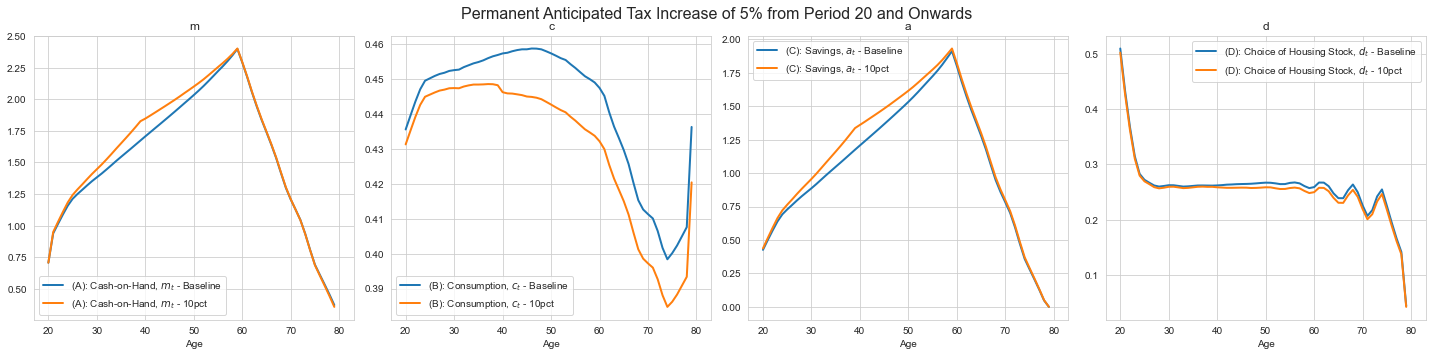

In [51]:
# a. unpack
par = model_negm.par
sim = model_negm.sim
sim_5pct = model_negm_5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Choice of Housing Stock, $d_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Permanent Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim,simvar)
    simdata_5pct = getattr(sim_5pct,simvar)
    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, label=f'{simvarlatex} - Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=(1,2)), lw=2, label=f'{simvarlatex} - 10pct')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvar}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

## Uanticipated Tax Increase

Create a copy of the original model solve with EGM and *unanticipated* permanent tax increase in period 20 (i.e., 21):

In [36]:
model_unanticipated5pct = model_negm.copy()

Replace the periods after 20 from the old_tax simulation with the new_tax simulation

In [38]:
for var in ['m', 'c', 'a','d']:
    sim_old = getattr(model_negm.sim, var)
    sim_new = getattr(model_negm_5pct.sim, var)
    sim_combined = np.copy(sim_old)  # Create a copy of the old simulation
    sim_combined[20:] = sim_new[20:]  # Replace the periods after 20 with the new simulation

    # Set the combined simulation in the original model
    setattr(model_unanticipated5pct.sim, f'{var}', sim_combined)

Checking They Jump to Correct (New) Optimal Path:

In [47]:
print(
    np.mean(model_negm.sim.c[10,:,0]),
    np.mean(model_unanticipated5pct.sim.c[10,:,0]),
    np.mean(model_unanticipated5pct.sim.c[30,:,0]),
    np.mean(model_negm_5pct.sim.c[30,:,0]),
)

0.43004627710746873 0.43004627710746873 0.6204701357613794 0.6204701357613794


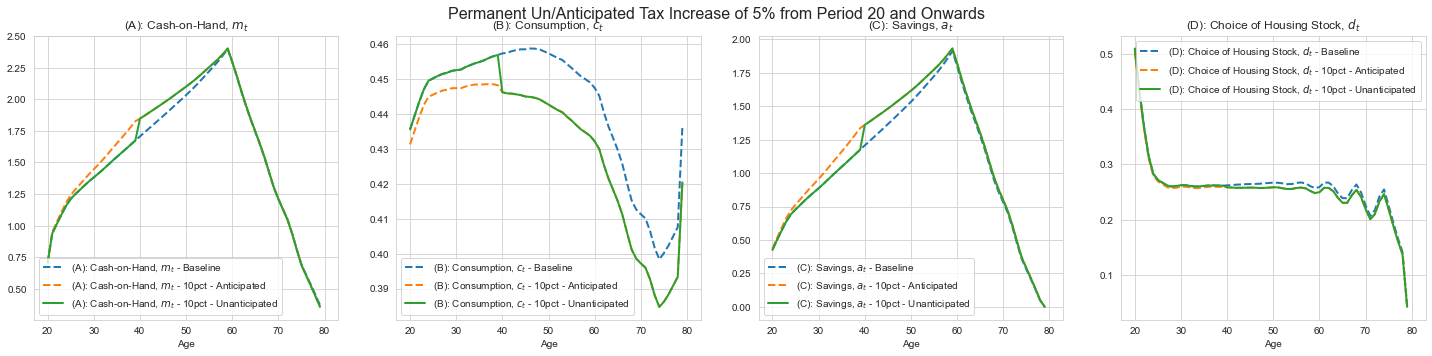

In [55]:
# a. unpack
par = model_negm.par
sim = model_negm.sim
sim_5pct = model_negm_5pct.sim
sim_unanticipated = model_unanticipated5pct.sim

simvarlist = [('m','(A): Cash-on-Hand, $m_t$'),
              ('c','(B): Consumption, $c_t$'),
              ('a','(C): Savings, $a_t$'),
              ('d','(D): Choice of Housing Stock, $d_t$')]

# b. figure
fig, axs = plt.subplots(1, len(simvarlist), figsize=(20, 5))

# add a title over the entire figure
fig.suptitle("Permanent Un/Anticipated Tax Increase of 5% from Period 20 and Onwards", fontsize=16)

age = np.arange(par.T)

for i, (simvar,simvarlatex) in enumerate(simvarlist):

    simdata = getattr(sim, simvar)
    simdata_5pct = getattr(sim_5pct, simvar)
    simdata_unanticipated = getattr(sim_unanticipated, simvar)  # data from combined model

    axs[i].plot(age, np.mean(simdata, axis=(1,2)), lw=2, linestyle = '--',label=f'{simvarlatex} - Baseline')
    axs[i].plot(age, np.mean(simdata_5pct, axis=(1,2)), lw=2,linestyle = '--', label=f'{simvarlatex} - 10pct - Anticipated')
    axs[i].plot(age, np.mean(simdata_unanticipated, axis=(1,2)), lw=2, label=f'{simvarlatex} - 10pct - Unanticipated')

    axs[i].legend(frameon=True)
    axs[i].grid(True)
    axs[i].set_xlabel('Age')
    axs[i].set_title(f'{simvarlatex}')

    # Change x-axis labels to show 20 years later
    xticks = axs[i].get_xticks()
    axs[i].set_xticks(xticks)  # Set tick positions, this line is actually redundant here because it's the same as before
    new_xticks = xticks + 20
    axs[i].set_xticklabels([int(val) if val.is_integer() else val for val in new_xticks])
    axs[i].set_xlim(-3, 63)

plt.tight_layout()
# Adjust the layout so that title does not overlap with the top plot
plt.subplots_adjust(top=0.9)
plt.show()

# Alternative Solution Methods

Solve with NVFI

In [ ]:
model_nvfi = DurableConsumptionModelClass(name='example_nvfi',par={'solmethod':'nvfi','do_print':False})
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()

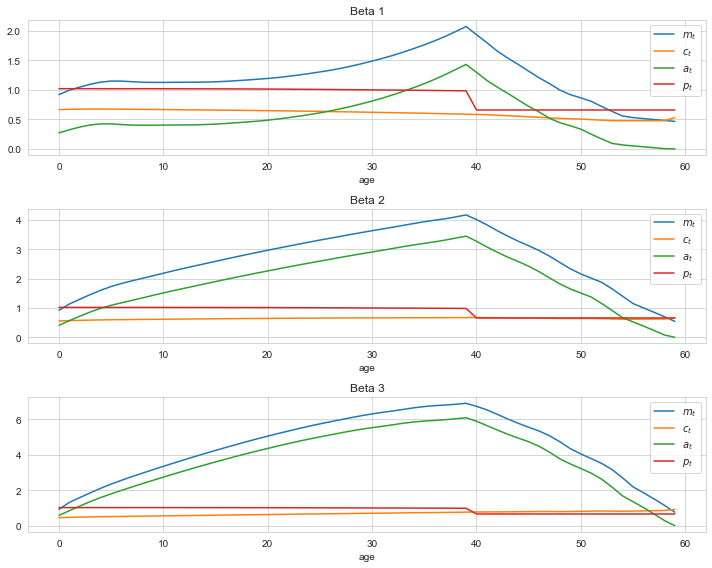

In [ ]:
# a. unpack
par = model_nvfi.par
sim = model_nvfi.sim

# b. figure
fig, axs = plt.subplots(len(par.Betas), 1, figsize=(10, 8))

simvarlist = [('m','$m_t$'),
              ('c','$c_t$'),
              ('a','$a_t$'),
             ('p','$p_t$')]

age = np.arange(par.T)

for b in range(len(par.Betas)):  # loop over beta dimension
    ax = axs[b]  # specify the current subplot

    for simvar, simvarlatex in simvarlist:
        # get simulation data
        simdata = getattr(sim, simvar)

        # calculate mean over individual dimension for each beta
        mean_data = np.mean(simdata[:, b, :], axis=1)

        # plot mean data
        ax.plot(age, mean_data, label=simvarlatex)

    ax.grid(True)
    ax.set_xlabel('age')
    ax.set_title(f'Beta {b+1}')
    ax.legend()

# adjust layout for better visualization
plt.tight_layout()
plt.show()

Solve model with VFI:

In [18]:
model_vfi = DurableConsumptionModelClass(name='example_vfi',par={'solmethod':'vfi','do_print':False})
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()

1
0
1
2
0
0
1
2
59
0
1
2
58
0
1


Traceback (most recent call last):
  File "/Users/hanschristian/Documents/GitHub/LostInOptimization/Jeppe/02. DurableConsumptionModel/DurableConsumptionModel.py", line 329, in solve
    vfi.solve_keep(t,b,sol,par,beta)
KeyboardInterrupt


KeyboardInterrupt: 

Now possible to compare solutions:

In [10]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

ImportError: cannot import name 'lifecycle_compare' from 'figs' (/Users/hanschristian/Documents/GitHub/LostInOptimization/Jeppe/02. DurableConsumptionModel/figs.py)

## Timing the model solution methods

### Timing function

In [ ]:
def run(name = 'baseline',
        rep = 5, # set to 5 in the paper
        load = False,
        solmethod = 'negm',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    if load == False:
        
        model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

### Settings

In [ ]:
models = dict()

basename = 'results'
T = 2
base = dict()
base['T'] = T

### Timings

In [ ]:
models['negm']  = run(name=f'{basename}', solmethod='negm', updpar=base)

In [ ]:
models['nvfi']  = run(name=f'{basename}', solmethod='nvfi', updpar=base)

In [ ]:
models['vfi']   = run(name=f'{basename}', solmethod='vfi', updpar=base)

### Time tables

In [ ]:
import tabs
main_models = [models['negm'],models['nvfi'],models['vfi']]
tabs.all(main_models,speedup=True)